In [1]:
# Download necessary libraries
!git clone https://github.com/scikit-maad/scikit-maad.git
!pip install librosa==0.8.1
!pip install scikit-maad

Cloning into 'scikit-maad'...
remote: Enumerating objects: 10599, done.
remote: Counting objects: 100% (1332/1332), done.
remote: Compressing objects: 100% (533/533), done.
remote: Total 10599 (delta 800), reused 1206 (delta 751), pack-reused 9267
Receiving objects: 100% (10599/10599), 183.22 MiB | 18.37 MiB/s, done.
Resolving deltas: 100% (7745/7745), done.
Updating files: 100% (267/267), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.8/203.8 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 14.3 MB/s eta 0:00:00
  Attempting uninstall: librosa
    Found existing installation: librosa 0.10.1
    Uninstalling librosa-0.10.1:
      Successfully uninstalled librosa-0.10.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.5/152.5 kB 3.9 MB/s eta 0:00:00


In [2]:
# Imports
import matplotlib.pyplot as plt
from maad import sound, util
from maad.rois import template_matching
import librosa
import librosa.display
import numpy as np

## Loadad one audiio recording which contains Hainan gibbon vocalisations

In [3]:
from google.colab import drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile

# Google Authentication
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download data files
downloaded = drive.CreateFile({'id':"1zOKrvxBxE2nS19kd8zm5xej15pKJZXyH"})
downloaded.GetContentFile('gibbon_template_audio.wav')

In [5]:
# load data
s, fs = sound.load("gibbon_template_audio.wav")

* Your task will be to find the three different events: single, two and three pulse calls.

* You'll find to identify templates.

* You should download the file and view it in Sonic Visualiser first to identify where in the file are these vocalisations!

* Generate the spectrogram in Sonic Visualiser and quickly scan for the vocalisation events, don't listen to the file, that will take too long. Rather, quickly scan using the scrollbar.

# Task 1: single pulse

There are 11 single-pulse events, how many did you find? Note some are more faiint than others, choose your template wisely

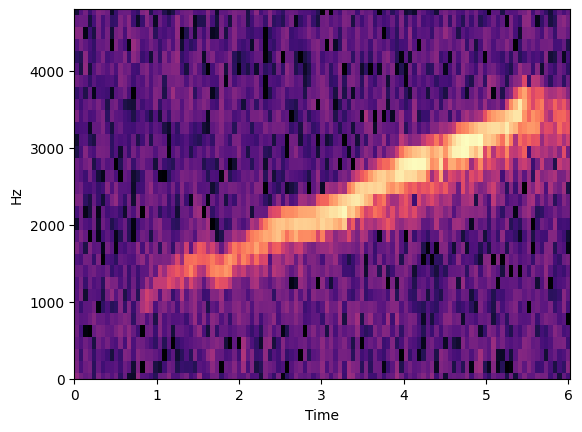

In [7]:
# Set spectrogram parameters
tlims = (3646,3652)# to do
flims =(1300,1600)# to do
nperseg =1024 # to do
noverlap = 512# to do
window = 'hann'
db_range = 90

# Compute spectrogram for template signal
Sxx_template, _, _, _ = sound.spectrogram(s, fs, window, nperseg, noverlap, flims, tlims)
Sxx_template = util.power2dB(Sxx_template, db_range)
librosa.display.specshow(Sxx_template, y_axis='linear', x_axis='time', sr=fs)

Cross correlation

In [8]:
#%%
# Compute the cross-correlation of spectrograms
# ---------------------------------------------
# Compute the cross-correlation of spectrograms and find peaks in the resulting signal using the `template matching` function.
# The template_matching functions gives temporal information on the location of the audio and frequency limits must be added.
peak_th = 0.5 # set the threshold to find peaks
# ---------------------------------------------
Sxx_audio, tn, fn, ext = sound.spectrogram(s, fs, window, nperseg, noverlap, flims)
Sxx_audio = util.power2dB(Sxx_audio, db_range)
xcorrcoef, rois = template_matching(Sxx_audio, Sxx_template, tn, ext, peak_th)

rois['min_f'] = flims[0] # this is predefined, since we're looking in this frequency range
rois['max_f'] = flims[1] # this is predefined, since we're looking in this frequency range
print(rois)

      peak_time  xcorrcoef        min_t        max_t  min_f  max_f
0   3482.080000   0.519011  3479.066667  3485.093333   1300   1600
1   3482.186667   0.520281  3479.173333  3485.200000   1300   1600
2   3511.893333   0.501079  3508.880000  3514.906667   1300   1600
3   3512.000000   0.506153  3508.986667  3515.013333   1300   1600
4   3512.106667   0.502394  3509.093333  3515.120000   1300   1600
5   3550.453333   0.532017  3547.440000  3553.466667   1300   1600
6   3550.560000   0.552561  3547.546667  3553.573333   1300   1600
7   3550.666667   0.548517  3547.653333  3553.680000   1300   1600
8   3576.160000   0.549508  3573.146667  3579.173333   1300   1600
9   3601.653333   0.558379  3598.640000  3604.666667   1300   1600
10  3601.920000   0.587566  3598.906667  3604.933333   1300   1600
11  3625.173333   0.624910  3622.160000  3628.186667   1300   1600
12  3625.280000   0.645296  3622.266667  3628.293333   1300   1600
13  3649.013333   0.992860  3646.000000  3652.026667   1300   

Plot the results

/usr/local/lib/python3.10/dist-packages/maad/util/miscellaneous.py:853: UserWarning: ROIs boundaries are outside time or frecuency signal limits. Clipping ROIS to valid boundaries.
  warnings.warn(


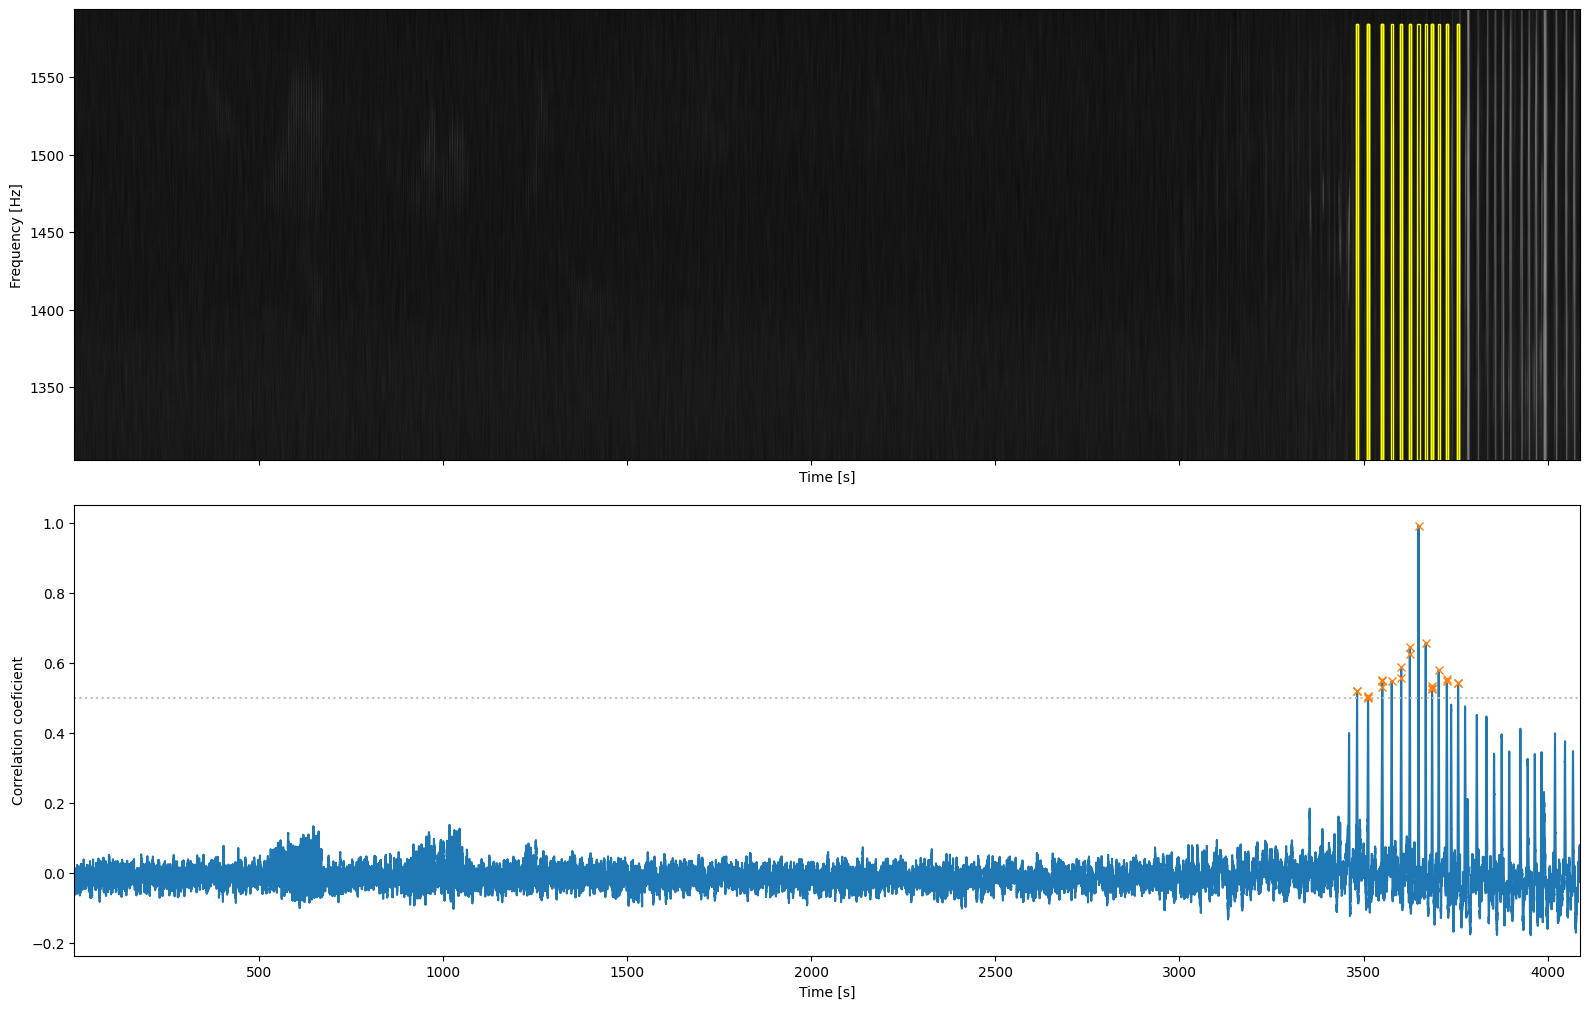

In [9]:
#%%
# Plot results
# ------------
# Finally, you can plot the detection results or save them as a csv file.
Sxx, tn, fn, ext = sound.spectrogram(s, fs, window, nperseg, noverlap, flims)
fig, ax = plt.subplots(2,1, figsize=(16, 10), sharex=True)
util.plot_spectrogram(Sxx, ext, db_range=80, ax=ax[0], colorbar=False)
util.overlay_rois(Sxx, util.format_features(rois, tn, fn), fig=fig, ax=ax[0])
ax[1].plot(tn[0: xcorrcoef.shape[0]], xcorrcoef)
ax[1].hlines(peak_th, 0, tn[-1], linestyle='dotted', color='0.75')
ax[1].plot(rois.peak_time, rois.xcorrcoef, 'x')
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Correlation coeficient')
plt.show()

let's find the peak times

In [10]:
rois['peak_time']

0     3482.080000
1     3482.186667
2     3511.893333
3     3512.000000
4     3512.106667
5     3550.453333
6     3550.560000
7     3550.666667
8     3576.160000
9     3601.653333
10    3601.920000
11    3625.173333
12    3625.280000
13    3649.013333
14    3668.480000
15    3685.546667
16    3685.653333
17    3685.813333
18    3703.680000
19    3725.653333
20    3725.760000
21    3756.373333
22    3756.480000
Name: peak_time, dtype: float64

and now visualise each peak

ValueError: num must be an integer with 1 <= num <= 10, not 11

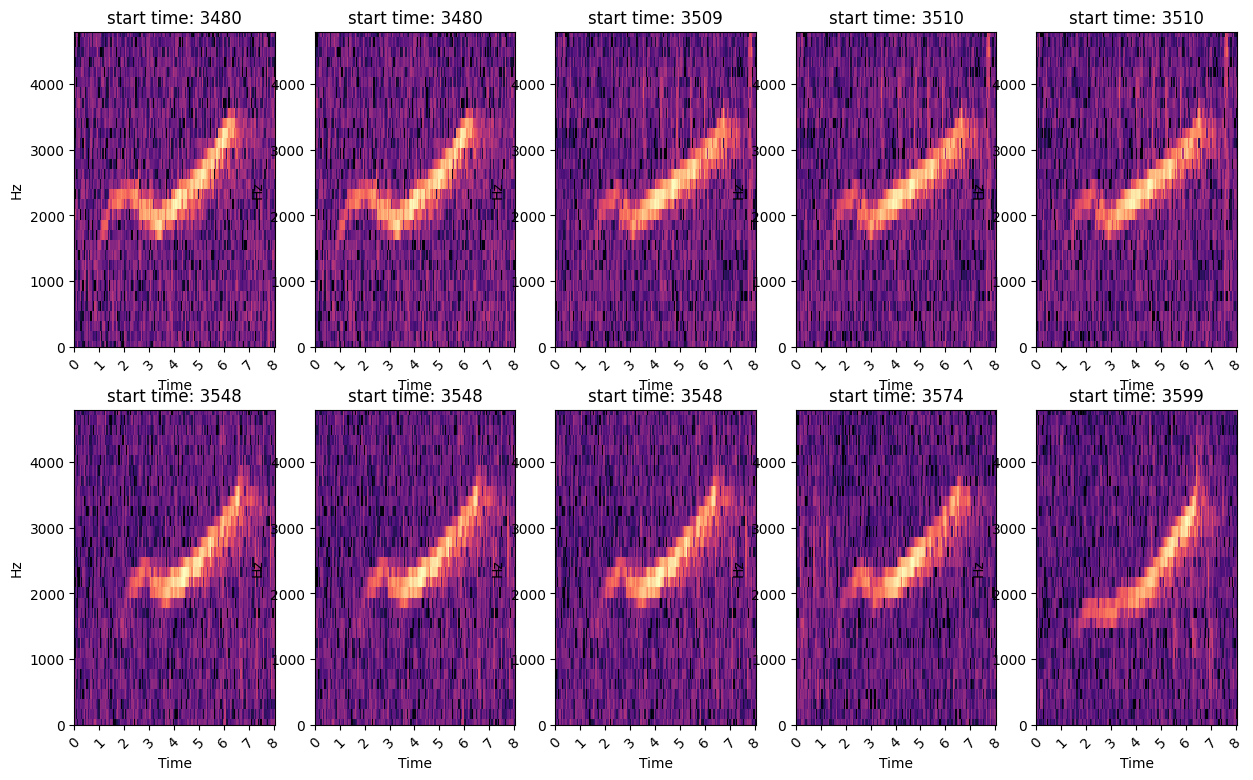

In [12]:
n = len(rois)
flims = (1300,1600)# to do
nperseg =1024 # to do
noverlap = 512# to do
window = 'hann'
db_range = 90


plt.figure(figsize=(15, 9))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, 5, i + 1)  # Use the correct index calculation

    index_to_check = i
    tlims = (rois['peak_time'][index_to_check]-4, rois['peak_time'][index_to_check]+4)
    # Compute spectrogram for template signal
    Sxx_template, _, _, _ = sound.spectrogram(s, fs, window, nperseg, noverlap, flims, tlims)
    Sxx_template = util.power2dB(Sxx_template, db_range)
    librosa.display.specshow(Sxx_template, y_axis='linear', x_axis='time', sr=fs)
    plt.title("start time: "+str(int(rois['peak_time'][index_to_check]-2)))
    plt.xticks(rotation=45)

plt.show()

# Task 2: two pulses

There are 6 two-pulse events, how many did you find?

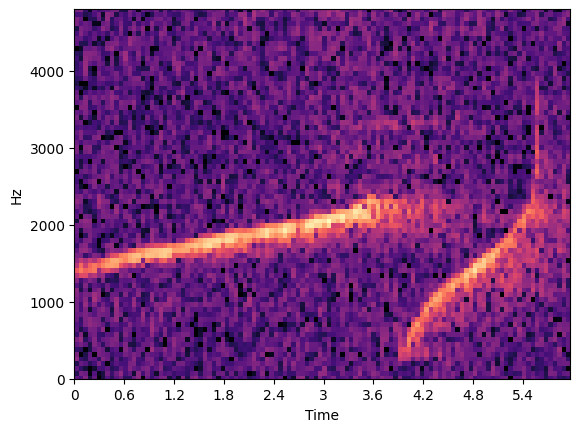

In [19]:
# Set spectrogram parameters
tlims =(3667,3673) # to do
flims =(1173,1890) # to do
nperseg = 1024# to do
noverlap = 512# to do
window = 'hann'
db_range = 90

# Compute spectrogram for template signal
Sxx_template, _, _, _ = sound.spectrogram(s, fs, window, nperseg, noverlap, flims, tlims)
Sxx_template = util.power2dB(Sxx_template, db_range)
librosa.display.specshow(Sxx_template, y_axis='linear', x_axis='time', sr=fs)

In [20]:
#%%
# Compute the cross-correlation of spectrograms
# ---------------------------------------------
# Compute the cross-correlation of spectrograms and find peaks in the resulting signal using the `template matching` function.
# The template_matching functions gives temporal information on the location of the audio and frequency limits must be added.
peak_th = 0.5 # set the threshold to find peaks
# ---------------------------------------------
Sxx_audio, tn, fn, ext = sound.spectrogram(s, fs, window, nperseg, noverlap, flims)
Sxx_audio = util.power2dB(Sxx_audio, db_range)
xcorrcoef, rois = template_matching(Sxx_audio, Sxx_template, tn, ext, peak_th)

rois['min_f'] = flims[0] # this is predefined, since we're looking in this frequency range
rois['max_f'] = flims[1] # this is predefined, since we're looking in this frequency range
print(rois)

     peak_time  xcorrcoef    min_t        max_t  min_f  max_f
0  3670.026667   0.992868  3667.04  3673.013333   1173   1890


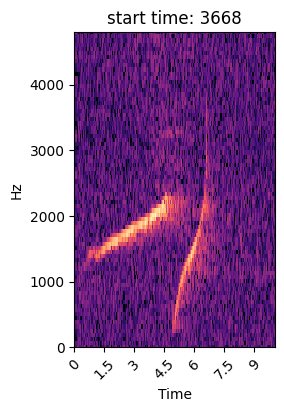

In [21]:
n = len(rois)
flims = (1173,1900)# to do
nperseg = 1024# to do
noverlap = 512# to do
window = 'hann'
db_range = 90

plt.figure(figsize=(15, 9))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, 5, i + 1)  # Use the correct index calculation

    index_to_check = i
    tlims = (rois['peak_time'][index_to_check]-4, rois['peak_time'][index_to_check]+6)
    # Compute spectrogram for template signal
    Sxx_template, _, _, _ = sound.spectrogram(s, fs, window, nperseg, noverlap, flims, tlims)
    Sxx_template = util.power2dB(Sxx_template, db_range)
    librosa.display.specshow(Sxx_template, y_axis='linear', x_axis='time', sr=fs)
    plt.title("start time: "+str(int(rois['peak_time'][index_to_check]-2)))
    plt.xticks(rotation=45)

plt.show()

# Task 3: three pulses

There are 11 three-pulse vocalisation events, how many did you find?

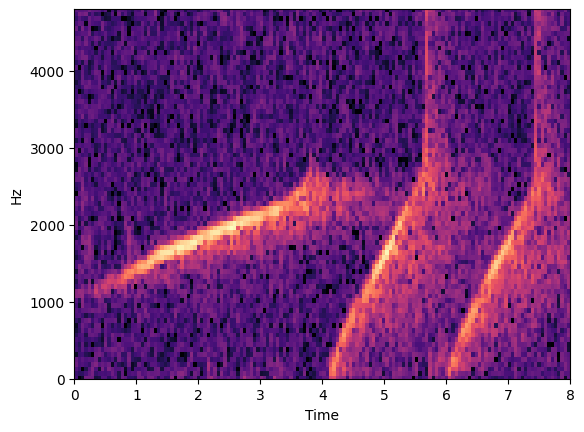

In [22]:
# Set spectrogram parameters
tlims =(3755,3763)# to do
flims = (1173,1900)# to do
nperseg = 1024# to do
noverlap = 512# to do
window = 'hann'
db_range = 90

# Compute spectrogram for template signal
Sxx_template, _, _, _ = sound.spectrogram(s, fs, window, nperseg, noverlap, flims, tlims)
Sxx_template = util.power2dB(Sxx_template, db_range)
librosa.display.specshow(Sxx_template, y_axis='linear', x_axis='time', sr=fs)

In [23]:
#%%
# Compute the cross-correlation of spectrograms
# ---------------------------------------------
# Compute the cross-correlation of spectrograms and find peaks in the resulting signal using the `template matching` function.
# The template_matching functions gives temporal information on the location of the audio and frequency limits must be added.
peak_th = 0.55 # set the threshold to find peaks
# ---------------------------------------------
Sxx_audio, tn, fn, ext = sound.spectrogram(s, fs, window, nperseg, noverlap, flims)
Sxx_audio = util.power2dB(Sxx_audio, db_range)
xcorrcoef, rois = template_matching(Sxx_audio, Sxx_template, tn, ext, peak_th)

rois['min_f'] = flims[0] # this is predefined, since we're looking in this frequency range
rois['max_f'] = flims[1] # this is predefined, since we're looking in this frequency range
print(rois)

     peak_time  xcorrcoef        min_t        max_t  min_f  max_f
0  3759.040000   1.001436  3755.040000  3763.040000   1173   1900
1  3809.706667   0.575697  3805.706667  3813.706667   1173   1900
2  3877.333333   0.572009  3873.333333  3881.333333   1173   1900
3  3927.946667   0.565396  3923.946667  3931.946667   1173   1900


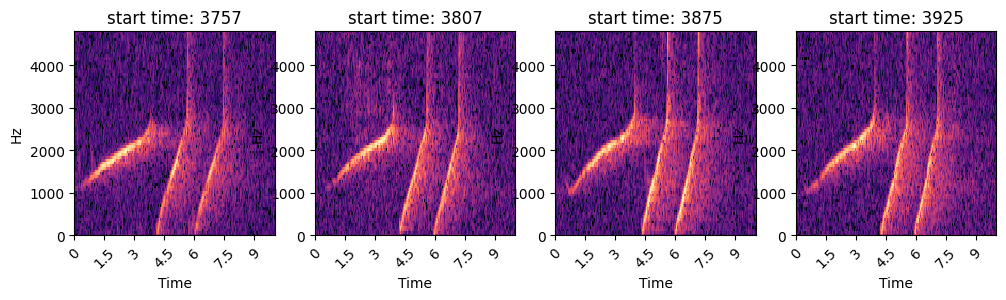

In [25]:
n = len(rois)
flims = (1173,1900)# to do
nperseg = 1024 # to do
noverlap = 512# to do
window = 'hann'
db_range = 90


plt.figure(figsize=(15, 9))
for i in range(n):

    # display original + noise
    ax = plt.subplot(3, 5, i + 1)  # Use the correct index calculation

    index_to_check = i
    tlims = (rois['peak_time'][index_to_check]-4, rois['peak_time'][index_to_check]+6)
    # Compute spectrogram for template signal
    Sxx_template, _, _, _ = sound.spectrogram(s, fs, window, nperseg, noverlap, flims, tlims)
    Sxx_template = util.power2dB(Sxx_template, db_range)
    librosa.display.specshow(Sxx_template, y_axis='linear', x_axis='time', sr=fs)
    plt.title("start time: "+str(int(rois['peak_time'][index_to_check]-2)))
    plt.xticks(rotation=45)

plt.show()